*Disclaimer:* This is just a notebook where I have tried to put forward some of my basic understanding on survival analysis. I am faily new at this, so do point out any mistakes or misconceptions if you come across any. Hope to learn more in the course of time.

## Survival Analysis:

Survival analysis is a branch of statistics which is mainly used for understanding the expected duration or time till an event (which might include death, failure of a product etc.) will occur. 

Example:
- *medical situation:* We are interested on knowing how long a subject suffering from a particular disease is meant to survive
- *in case of mechanical systems:* We might be interested in knowing how long we have till a certain machine fails.

### Role of Survival Analysis in Cancer Studies:

In this case, the main motivation is to find out the clinical characteristics (age, gender, etc.) of a patient (with lung cancer) on which his/her survival depends. 

#### Types of Models used in Survival Analysis

There are different types of ways in which we can perfrom survival analysis. It is perfomed in several ways like when we define a group. Some of them are Kaplan Meier Curves, Cox Regression Models, Hazard Function, Survival Function etc.

> When the survival Analysis is done to compare the survival analysis of 2 different groups, we typically tend to use a Log-Rank test.

> When the Survival Analysis is done to describe the categorical and quantitative variables on survival we tend to use a Cox proportional hazards regression, Parametric Survival Models etc.

#### Types of Models used in Survival Analysis

There are different types of ways in which we can perfrom survival analysis. Some of them might include: 
- Exponential Models (parametric model)
- Kaplan Meier Models (non parametric model)
- Cox Regression Models (semi parametric model)

> In general terms, we tend to go for a parametric model whenever we have a distribution of data which follows a Gaussian distribution (normally distributed). On the other hand we tend to go for non-parametric models whenever we have data which does not assume any prior distribution pattern. 

> When the Survival Analysis is done to take a look at the survival curves of the subjects, the most common approach is to go for a Kaplan Meier Model. One of the disadvantages of the Kaplan Meier model though is that we cannot estimate hazards from the Kaplan Meier Curves. For that we need to apply any other model like the Nelson-Aalen model (for estimating the hazard rates) or the Cox-proportional model (for estimating the hazard ratios). In case, we are interested in understanding which features of a subject are playing significant roles in determining the survivability, then a cox-proportional model is a fairly popular choice.

### Data Censoring

In general survival analysis deals with the occurrence of an event of interest. The event of interest in this case is the death of a patient suffering from lung cancer. However, there might be possibilities that the event we are interest in does not occur.
> *Such observations, where we are not sure on whether an event of interest has already occurred are known as censored observations*. 

*Left Censoring*: In this type of censoring, the event cannot be observed due to some reason. There might be chances that the event had already occurred before the experiment started, such as the person might have already died before the experiment begins. 

*Right Censoring*: In this case, the event of interest has not yet occurred for the individual under consideration. Basically, the person is still alive before the ending period of the analysis and the event of interest i.e., death (in this case) might or might not occur after the period under consideration.

*Interval Censoring*: In this type of censoring, we only have data for a specific interval of time. Hence it is possible that the event of interest for the person responsible does not occur during that time interval.

> In this scenario, all censored data are considered to be *non-informative* i.e., being censored is not related to the probability of the event (death, in this case) occurring.

In [ ]:
# importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install lifelines
from lifelines import KaplanMeierFitter

### Overview of the dataset
#### Looking at the shape, features, data types

In [ ]:
df = pd.read_csv('../input/ncctg-lung-cancer-data/cancer.csv')
df.head()

In [ ]:
df.shape

### Dataset Attributes Overview:

| Attribute  |                         Description                               |
|:---------- |:------------------------------------------------------------------|
| inst       | Institute Code                                                    |
| time       | Survival time in days                                             |
| status     | Censoring status; 1= censored; 2 = dead                           |
| age        | Age of the subject in years                                       |
| ph.ecog    | Ecog performance score; 0: good, 5: dead                          |
| ph.karno   | Karnofsky performance score; 0: bad; 100: good rated by physician |
| pat.karno  | Karnofsky performance score as rated by patient                   |
| meal.cal   | Calories consumed at meals                                        |
| wt.loss    | Weight loss in last six months                                    |

### The Karnofsky Performance Scale Index

The Karnofsky Performance Scale Index allows patients to be classified as to their functional impairment. This can be used to compare effectiveness of different therapies and to assess the prognosis in individual patients. The lower the Karnofsky score, the worse the survival for most serious illnesses.
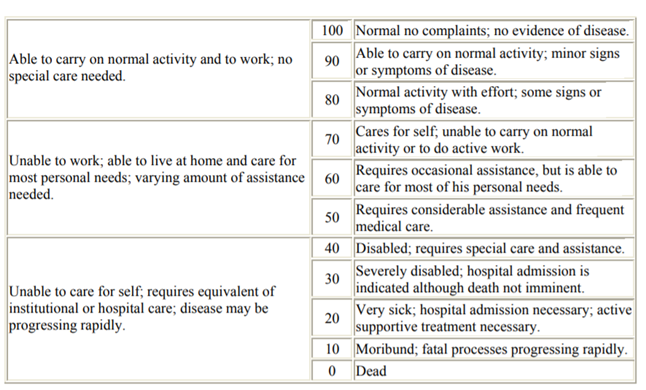

Ecog Performance Score:

|    Grade   |                  Ecog Performance Status                                       |
|:---------- |:-------------------------------------------------------------------------------|
|      0     | Fully active able to carry on all pre-disease performance without restriction. |
|      1     | Restricted in physically strenuous activity but ambulatory and able to carry out work of a light or sedentary nature, e.g., light house work, office work                                             |
|      2     | Ambulatory and capable of all selfcare but unable to carry out any work activities; up and about more than 50% of waking hours  |
|      3     | Capable of only limited selfcare; confined to bed or chair more than 50% of waking hours                                        |
|      4     | Capable of only limited selfcare; confined to bed or chair more than 50% of waking hours                                        |
|      5     | Karnofsky performance score; 0: bad; 100: good rated by physician |

### Checking for missing values within the dataset

In [ ]:
df.info()

In [ ]:
## checking null values
df.isnull().sum()

In [ ]:
# Looking at the rows with null values
df[df.isnull().any(axis=1)]

### Dealing with Null values:

In this case, there are a total of 228 data points. Out of these there 6 attributes which have missing values in the dataset which are as follows: 
1. `Unnamed: 0` is being dropped from the dataset as it is basically the row numbers
2. `inst` (this attribute will eventually be ignored and dropped from the dataset as it does not have considerable contribution)
3. From the rest of the attributes with missing values, the missing rows will be dropped only while doing any analysis which are dependent on only that particular attribute.

In [ ]:
df.drop(['Unnamed: 0', 'inst'], axis=1, inplace=True)

In [ ]:
# dataframe after dropping the above two attributes:
df.head()

## Survival Probability and Survival Function

### Survivability:

Survival Function $S(t) = P(T > t)$, Probability of survival beyond time 't'

### Hazard and Hazard Ratio

Hazard: <br>
$HAZ = P(T < t+ \delta | T > t)$, Probability of dying in the next few second ($\delta$ seconds), considering the subject is alive at the moment.

Hazard Ratio $(HR) = \frac{HAZ,\ x\ =\ 1}{HAZ,\ x\ =\ 0}$

Here, Hazard ration basically, gives an idea about the relative hazards i.e., the hazard of a group who are exposed to some event $x = 1$ to the group who are not exposed i.e., $x = 0$

Example: if $HR = 2$, in this case, we can say, that, at an instance of time, a group of individuals who were *exposed to a risk factor* have **twice the chances of dying** than the group of individuals who were *not exposed*.

## Overview of the Kaplan-Meier Estimation

The Kaplan-Meier estimator is a non-parametric statistical model used to estimate the survival function (probability of a person surviving) from the lifetime data. Here the KM model is being used to measure the fraction of patients living for a specific time after treatment or diagnosis of the cancer.


#### Kaplan-Meier Equation

\begin{align}
S(t_i) = S(t_{i-1}) * (1-\frac{d_i}{n_i})
\end{align}


### Example:
> #### 1. Survival probability at t=1:
\begin{align}
S(1) & = S(0) * (1-\frac{d_1}{n_1}) = (1-\frac{d_1}{n_1})\\
\end{align}

> #### 2. Survival probability at t=2:
\begin{align}
S(2) & = S(1) * (1-\frac{d_2}{n_2})\\
\end{align}

> #### 3. Survival probability at t=3:
\begin{align}
S(3) & = S(2) * (1-\frac{d_3}{n_3})\\
\end{align}

In a more generalized way, the probability of survival for a particular time can be given as:

\begin{align}
S_t = \frac{Number\ of\ subjects\ at\ risk\ at\ the\ start - Number\ of\ subjects\ that\ died} {Number\ of\ subjects\ at\ risk\ at\ the\ start}
\end{align}

Survival probability follows the concept of *conditional probability*, where for a person to be alive on the *nth* day, he should have been alive for the last *n-1* days. Hence we are looking at the past values also, and the probability of the *nth* day depends on the probability of the previous days. 

So to summarize, from the above equation we get:

\begin{equation*}
S(n)   = S(1) * S(2) * S(3) * ... * S(n-1) * S(n)
\end{equation*}

### Creating Seperate column for "Event of Interest - Death" from the status column

Person is *dead* when `status = 1`

Person is *alive* when `status = 2`

In [ ]:
df.loc[df['status'] == 1, 'dead'] = 0
df.loc[df['status'] == 2, 'dead'] = 1

In [ ]:
df.head()

### Finding the number of days a person was alive before they died.

In [ ]:
durations = df['time']
event_obs = df['dead']

kmf = KaplanMeierFitter()
kmf.fit(durations, event_obs)

### Event Table Overview from KM Estimator

The Event table consists of the following attributes which will be consulted to in future:

> 1. **event_at**: It stores the value of the timeline for the dataset concerned. i.e., when was the patient observed in the observation. In this case, it is in days. It stores the number of survival days for each subject.

> 2. **observed**: These are the number of people that died during the time frame of the experiment. To generalize these are basically the people who met out *event of interest*.

> 3. **entrance**: It contains the number of new people encountered in a given timeline. There might be cases, where new groups of patients are diagnosed with the disease. The entrance column, basically, accounts for that. 

> 4. **censored**: Since we are mainly concerned in finding the survival probability of a patient. At the end of the experiment, if the person is still alive, then they will be added to the censored category. 

> 5. **removed**: It stores the value of patients who are no longer a part of our experiment. A patient will fall in this category if they either die or are censored.
\begin{align}
removed = observed + censored
\end{align}

> 6. **at_risk**: It stored the value of the number of current patients who are under the observation. At the beginning, it will be nothing but the total number of patients we are concerned during the experiment. But later on, the value will increase with the addition of any newly diagnosed patient during that particular timeframe.
\begin{align}
at\_risk = current\ patients\ at\_risk + entrance - removed
\end{align}

In [ ]:
# looking at the event table
event_tab = kmf.event_table
print("Event Table:")
event_tab.head(5)

From the above event table the survival probability which was given as:
\begin{align}
S_t = \frac{Number\ of\ subjects\ at\ risk\ at\ the\ start - Number\ of\ subjects\ that\ died} {Number\ of\ subjects\ at\ risk\ at\ the\ start}
\end{align}

Can be interpreted as (at time t = n):
\begin{align}
S_{(t=n)} = \frac{at\_risk_n - observed_n}{at\_risk_n}
\end{align}

To be clear, 
for t = 0:
\begin{align}
S_0 = \frac{228-0}{228}
\end{align}

for t = 11, from the event table we look at event_at t = 11 row i.e.,:
\begin{align}
S_{11} = \frac{227-3}{227}
\end{align}

In [ ]:
# survival probability at time t=0:

# theoretical checking of random t values (t = 0, t = 11, t = 13)

# for t = 0 i.e., first row in event table
first_row = event_tab.iloc[0,:]
survival_at_0 = (first_row.at_risk - first_row.observed) / first_row.at_risk
print("Survival at time t = 0 :", survival_at_0)

# for t = 11 i.e., third row in even table
third_row = event_tab.iloc[2,:]
survival_at_11 = (third_row.at_risk - third_row.observed) / third_row.at_risk
print("Survival at time t = 11:", round(survival_at_11, 3))

# for t = 13 i.e., fifth row in even table
fifth_row = event_tab.iloc[4,:]
survival_at_13 = (fifth_row.at_risk - fifth_row.observed) / fifth_row.at_risk
print("Survival at time t = 13:", round(survival_at_13, 3))

In our case, we are required to find the conditional probability till a particular t value, to obtain the actual survival probability.

So basically, at t = 0
\begin{align}
S(0) = S_0 = 1
\end{align}

Generalized version, at t = n:
\begin{align}
S_n = S_0 * S_1 * S_2 * ... * S(n)
\end{align}

So, for t = 11:
\begin{align}
S_{11} = S_0 * S_5 * S_{11}
\end{align}

In [ ]:
# Using kmf's predict function to call out the survival probabilities 
kmf.predict(11)

In [ ]:
# looking at all the KM estimates
survival_ls = kmf.survival_function_
survival_ls.head()

In [ ]:
# Plotting the event observed against the timeframe of reference
kmf.plot(ci_show=False)
plt.title("Kaplan-Meier Estimation")
plt.xlabel("Number of days")
plt.ylabel("Probability of survival");

### Median Survival Period (in days)

In [ ]:
# looking at the median number of survival days i.e., the number of days, on an average, 50% of the patients survived.
print("The median survival time:", kmf.median_survival_time_, "days.")

#### Inference:
> From the value of the median survival days, we can say, that after the diagnosis of lung cancer, a patient, on an average is alive for **310 days**

### Survival Probability with confidence intervals

In [ ]:
kmf.confidence_interval_survival_function_

### Plotting the graph for survival probability with confidence interval

In [ ]:
confidence_surv_func = kmf.confidence_interval_survival_function_

plt.plot(confidence_surv_func["KM_estimate_lower_0.95"], label = "Lower 95%")
plt.plot(confidence_surv_func["KM_estimate_upper_0.95"], label = "Upper 95%")
plt.title("Survival Function with Confidence Interval")
plt.xlabel("Number of days")
plt.ylabel("Survival Probability")
plt.legend();

In [ ]:
event_tab

### Investigation on a person dying:

\begin{align}
S_t = \frac{Number\ of\ subjects\ who\ died\ at\ time\ t} {Number\ of\ subjects\ at\ risk\ just\ before\ time\ t}
\end{align}

Here the denominator value is subjected at risk in the previous row.

#### Cases when a person dies:

The probability that a person dies at time t = 0: 
\begin{align}
\frac{observed}{at\_risk}
\end{align}

At t = 0:
\begin{align}
P_{die(0)} = \frac{0}{228} = 0
\end{align}

At t = 5:
\begin{align}
P_{die(5)} = \frac{1}{228} = 0 = 0.004385
\end{align}

At t = 11:
\begin{align}
P_{die(11)} = \frac{3}{228} = 0 = 0.013157
\end{align}

#### The formula for cumulative density can be given as:

\begin{align}
P_{(die(t_i))} = \sum \limits _{t_i <= t} P_{die(t_i)}
\end{align}

#### The cumulative density at t = 0:
\begin{align}
P_{(die(0))} = P_{die(t_0)} = 0
\end{align}

#### The cumulative density at t = 5:
\begin{align}
P_{(die(5))} = P_{die(t_0)} + P_{die(t_5)} = 0 + 0.004385 = 0.004385
\end{align}

#### The cumulative density at t = 11:
\begin{align}
P_{(die(11))} = P_{die(t_0)} + P_{die(t_5)} + P_{die(t_{11})} = 0 + 0.004385 + 0.01315= 0.01754
\end{align}

#### The cumulative density at t = n:
\begin{align}
P_{(die(n))} = P_{die(t_0)} + P_{die(t_1)} + ... + P_{die(t_n)}
\end{align}

In [ ]:
# finally the cumulative density:
kmf.cumulative_density_

In [ ]:
# plotting the graph for the cumulative density:
kmf.plot_cumulative_density(ci_show=False)
plt.title("Graph showing cumulative density")
plt.xlabel("Number of days")
plt.ylabel("Probability of a person's death");

> As the number of survival days increase, the probability of a person dying decreases.

### Plotting the graph for cumulative density with a confidence interval

In [ ]:
confidence_cumulative_density = kmf.confidence_interval_cumulative_density_
confidence_cumulative_density

In [ ]:
plt.plot(confidence_cumulative_density["KM_estimate_lower_0.95"], label = "Lower 95%")
plt.plot(confidence_cumulative_density["KM_estimate_upper_0.95"], label = "Upper 95%");

### The median time to an event:

The median survival time can help us get the *the amount of time remaining to an event*

In [ ]:
# Calculating the conditional median time to the event

kmf.conditional_time_to_event_

### Graph for the median time to an event

In [ ]:
# Conditional median time left for event:

median_time_to_event = kmf.conditional_time_to_event_

plt.plot(median_time_to_event, label = "Median Time Remaining to Event")
plt.title("Median Time Remaining to Event")
plt.xlabel("Total Days")
plt.ylabel("Conditional Median time to Event")
plt.legend();

# Estimating Hazard Rates using Nelson-Aalen

### Hazard Function $H(t)$
Using the Kaplan-Meier survival function, we can get the probability of an event of interest (death in this case) which is not occurring by that time. Although the survival functions are a great way to summarize and visualize the survival dataset; we can also visualize the aggregate information on survival using the Nelson-Aalen hazard function $h(t)$. The hazard function $h(t)$ gives us the probability that a subject under observation at time $t$ has an event of interest (death) at that time. 
>To get the information about the hazard function, we cannot transform the Kaplan-Meier estimator. For that, there is a proper *nonparametric* estimator of the *cumulative hazard function*:

### Cumulative Hazard Function:
\begin{align}
\hat{H}(t) = \sum \limits _{t_i <= t} \frac{d_i}{n_i}
\end{align}

Where,
\begin{align}
\hat{H}(t) = Cumulative\ hazard\ probability\\
d_i = The\ number\ of\ events\ at\ time\ t_i\\
n_i = The\ number\ of\ subjects\ alive\ at\ time\ t_i\\
\end{align}

In [ ]:
# import the Nelson Aalen hazard model
from lifelines import NelsonAalenFitter

In [ ]:
# object for NelsonAalenFitter

naf = NelsonAalenFitter()

In [ ]:
# Fitting the data

naf.fit(df['time'], event_observed=df['dead'])

In [ ]:
# finding the cumulative hazard:

naf.cumulative_hazard_

In [ ]:
# plotting the cumulative hazard graph

naf.plot_cumulative_hazard(ci_show=False)
plt.title("Cumulative Probability for Event of Interest (Death)")
plt.xlabel("Number of Days")
plt.ylabel("Cumulative Probability of subject's death");

# Comparison of the different groups of the attributes using the Kaplan Meier Curve

In [ ]:
# creating a separate of the actual dataframe for this phase of analysis
df2 = df.copy()

In [ ]:
# renaming columns for simplicity

df2 = df2.rename(columns={'meal.cal': 'meal_cal', 'wt.loss': 'wt_loss', 'ph.karno': 'ph_karno', 'ph.ecog': 'ph_ecog', 'pat.karno': 'pat_karno'})

### 1. Dividing the population into two groups by the sex of the subject to check if the sex of a subject has any affect on the survival.

In [ ]:
# creating 2 objects for the two groups:

kmf_males = KaplanMeierFitter()
kmf_females = KaplanMeierFitter()

In [ ]:
# dividing the data into groups:

males = df2.query("sex == 1")
females = df2.query("sex == 2")

In [ ]:
# fitting the data into the models. 

kmf_males.fit(durations= males['time'], event_observed= males['dead'], label= "Males")
kmf_females.fit(durations= females['time'], event_observed= females['dead'], label= "Females")

In [ ]:
# plotting the graph for the two groups:

kmf_males.plot(ci_show = False)
kmf_females.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability of Males and Females");

### Inference
> From the graph it can be inferred that males have a comparatively lower chnaces of survival compared to females. 

### 2. Dividing the population into two groups by the ages of the subjects to check if the age of a subject has any affect on the survival.

In [ ]:
# dividing the age into different categories : 1 -> greater than 70 and 0 -> lesser than 70
df_age_cats = df2.copy()

df_age_cats.loc[df_age_cats['age'] >= 70, 'age_cat'] = 1
df_age_cats.loc[df_age_cats['age'] < 70, 'age_cat'] = 0

In [ ]:
df_age_cats.head(2)

In [ ]:
# dividing the data into groups:

old = df_age_cats.query("age_cat == 1")
young = df_age_cats.query("age_cat == 0")

In [ ]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_old = KaplanMeierFitter()
kmf_young = KaplanMeierFitter()

kmf_old.fit(durations= old['time'], event_observed= old['dead'], label= "More than 70 years")
kmf_young.fit(durations= young['time'], event_observed= young['dead'], label= "Less than 70 years")

In [ ]:
# plotting the graph for the two groups:

kmf_old.plot(ci_show = False)
kmf_young.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability of the different age groups");

### Inference

> From the graph above, it can be inferred that subjects who are older than 70 years have a comparatively lower chances of survival compared to subjects younger than 70 years.

### 3. Dividing the population into two groups by the average weight loss of the subjects to check if the weight loss has any affect on the survival.

In [ ]:
# finding the average meal calories and plotting a historgram for reference
df_wt_loss = df2.copy()

df_wt_loss['wt_loss'].hist()
plt.title("Distribution of the different weight loss");

In [ ]:
print("The mean weight loss: ", df_wt_loss['wt_loss'].mean())

In [ ]:
# dividing the age into 2 categories : 
# 1 -> people who were having a weight loss more than the average weight loss
# 0 -> people who were having a below average weight loss.

df_wt_loss.loc[df_wt_loss['wt_loss'] > 9.83177570093458, 'wt_loss_cat'] = 1
df_wt_loss.loc[df_wt_loss['wt_loss'] <= 9.83177570093458, 'wt_loss_cat'] = 0

In [ ]:
# dividing the data into groups:

above_avg_wt_loss = df_wt_loss.query("wt_loss_cat == 1")
below_avg_wt_loss = df_wt_loss.query("wt_loss_cat == 0")

In [ ]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_above_avg_wt_loss = KaplanMeierFitter()
kmf_below_avg_wt_loss = KaplanMeierFitter()

kmf_above_avg_wt_loss.fit(durations = above_avg_wt_loss['time'], event_observed = above_avg_wt_loss['dead'], label= "Above average weight loss")
kmf_below_avg_wt_loss.fit(durations = below_avg_wt_loss['time'], event_observed = below_avg_wt_loss['dead'], label= "Below average weight loss")

In [ ]:
# plotting the graph for the two groups:

kmf_above_avg_wt_loss.plot(ci_show = False)
kmf_below_avg_wt_loss.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the weights lost");

### Inference

> From the graph above, it can be inferred that subjects having above average weight loss have lower chances of survival.

### 4. Dividing the population into two groups the ph.karno scores

In [ ]:
df2['ph_karno'].hist();
plt.title("Distribution of Physician Karnofsky Scores");

### Group Division:

A ph.karno score of >= 80 will consider all patiens who are able to carry on normaly activity without special care. People with less than 80 are considered actually ill with people having >  40 scores as really sick.

Considering this, the two groups are made as:
1. People with <= 80 pat.karno score
2. People with > 80 pat.karno score

In [ ]:
# dividing the age into 2 categories : 
# 1 -> people who have a ph.karno >= 80 -- healthy
# 0 -> people who have a ph.karno < 80 -- sick
df_pat_karno = df2.copy()

df_pat_karno.loc[df_pat_karno['pat_karno'] >= 80, 'pat_karno_cat'] = 1
df_pat_karno.loc[df_pat_karno['pat_karno'] < 80, 'pat_karno_cat'] = 0

In [ ]:
# dividing the data into groups:

pat_karno_healthy = df_pat_karno.query("pat_karno_cat == 1")
pat_karno_sick = df_pat_karno.query("pat_karno_cat == 0")

In [ ]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_pat_karno_healthy = KaplanMeierFitter()
kmf_pat_karno_sick = KaplanMeierFitter()


kmf_pat_karno_healthy.fit(durations = pat_karno_healthy['time'], event_observed = pat_karno_healthy['dead'], label= "Pat-Karno greater than 80 (Healthy)")
kmf_pat_karno_sick.fit(durations = pat_karno_sick['time'], event_observed = pat_karno_sick['dead'], label= "Pat-Karno less than 80 (Sick)")

In [ ]:
# plotting the graph for the two groups:

kmf_pat_karno_healthy.plot(ci_show = False)
kmf_pat_karno_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the Patient Karnofsky scores");

### Inference

> From the graph above, it can be inferred that subjects with Patient Karnofsky score less than 80 have lower chances or survival.

### 5. Dividing the population into two groups the ph.karno scores

In [ ]:
df2['ph_karno'].hist();
plt.title("Distribution of Physician Karnofsky Scores");

### Group Division:

A ph.karno score of >= 80 will consider all patiens who are able to carry on normaly activity without special care. People with less than 80 are considered actually ill with people having >  40 scores as really sick.

Considering this, the two groups are made as:
1. People with <= 80 ph.karno score
2. People with > 80 ph.karno score

In [ ]:
# dividing the age into 2 categories : 
# 1 -> people who have a ph.karno >= 80 -- healthy
# 0 -> people who have a ph.karno < 80 -- sick
df_ph_karno = df2.copy()

df_ph_karno.loc[df_ph_karno['ph_karno'] >= 80, 'ph_karno_cat'] = 1
df_ph_karno.loc[df_ph_karno['ph_karno'] < 80, 'ph_karno_cat'] = 0

In [ ]:
# dividing the data into groups:

ph_karno_healthy = df_ph_karno.query("ph_karno_cat == 1")
ph_karno_sick = df_ph_karno.query("ph_karno_cat == 0")

In [ ]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_ph_karno_healthy = KaplanMeierFitter()
kmf_ph_karno_sick = KaplanMeierFitter()

kmf_ph_karno_healthy.fit(durations = ph_karno_healthy['time'], event_observed = ph_karno_healthy['dead'], label= "Ph-Karno greater than 80 (Healthy)")
kmf_ph_karno_sick.fit(durations = ph_karno_sick['time'], event_observed = ph_karno_sick['dead'], label= "Ph-Karno less than 80 (Sick)")

In [ ]:
# plotting the graph for the two groups:

kmf_ph_karno_healthy.plot(ci_show = False)
kmf_ph_karno_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the Physician Karnofsky scores");

### Inference

> From the graph above, it can be inferred that subjects having Physician Karnofsky score less than 80 have lower chances or survival.

### 6. Dividing the population into two groups by the ph.ecog scores

In [ ]:
df2['ph_ecog'].hist()
plt.title("Distribution of Physician Ecog Scores");

### Group Division:

A ph.karno score of less than equal to 1 will consider all patiens who are able to carry on normaly activity without special care. People with greater than 1 are considered actually ill.

Considering this, the two groups are made as:
1. People with >= 1 ph.karno score
2. People with < 1 ph.karno score

In [ ]:
# dividing the age into 2 categories : 
# 1 -> people who have a ph.ecog <= 1 -- healthy
# 0 -> people who have a ph.karno > 1 -- sick
df_ph_ecog = df2.copy()

df_ph_ecog.loc[df_ph_ecog['ph_ecog'] <= 1, 'ph_ecog_cat'] = 1
df_ph_ecog.loc[df_ph_ecog['ph_ecog'] > 1, 'ph_ecog_cat'] = 0

In [ ]:
# dividing the data into groups:

ph_ecog_health = df_ph_ecog.query("ph_ecog_cat == 1")
ph_ecog_sick = df_ph_ecog.query("ph_ecog_cat == 0")

In [ ]:
# creating kmf objects for the two groups and fitting the categorized data

kmf_ph_ecog_healthy = KaplanMeierFitter()
kmf_ph_ecog_sick = KaplanMeierFitter()

kmf_ph_ecog_healthy.fit(durations = ph_ecog_health['time'], event_observed = ph_ecog_health['dead'], label= "Ph-Ecog lesser than 1 (Healthy)")
kmf_ph_ecog_sick.fit(durations = ph_ecog_sick['time'], event_observed = ph_ecog_sick['dead'], label= "Ph-Ecog greater than 1 (Sick)")

In [ ]:
# plotting the graph for the two groups:

kmf_ph_ecog_healthy.plot(ci_show = False)
kmf_ph_ecog_sick.plot(ci_show = False)

plt.xlabel("Days passed")
plt.ylabel("Survival Probability")
plt.title("Survival Probability according to the Physician Ecog scores");

### Inference

> From the above graph here, it can be inferred that the subjects having Physician Ecog scores less than 1 have lower chances of survival.

# Application of the Cox-proportional Hazard model

### Introduction on the model:
The cox-proportional hazard model is a regression model generally used in medical research to determine the relationship between the survival time of a subject and one or more predictor variables. In generic terms, it can be explained to be used for finding how the different attributes like age, gender, height, weight etc. affect the survival time of a subject.

### Significance of Cox-Ph model over the others:

1. Here, the interest is mostly to find which covariate has more significance effect on the survivability of a subject. Hence, the more important point of interest is the hazard ration $e^{b_i}$. Hence, the application of the cox-proportional model seems like a better fit. Any other models could have been chosen if main point of interest was on the prediction of an individual surviving beyond a particular time.
2. The Cox-Ph model allows the $HAZ$ to fluctuate along with time (it is a function of time). On the other hand, the Weibull model has the $HAZ$ which is proportional to time i.e., the $HAZ$ either increases or decreases with proportion to time.
2. While other models are used for comparing only one variable at a time and operating on categorical variables like gender, status etc., the Cox-Ph model can be used for non-categorical variables like age, weight, height etc.

### Basics of Cox-proportional Hazard Model

\begin{align}
h(t) = h_0(t)  * e^{(b_1x_1 + b_2x_2 + ... + b_nx_n)}
\end{align}

Taking natural logarithm of both sides:
\begin{align}
ln(h(t)) = ln(h_0(t))  * b_1x_1 + b_2x_2 + ... + b_nx_n
\end{align}

$
Where,\\
t                   = survival\ time\\
h(t)                = hazard\ function\\
x_1, x_2, ..., x_n  = covariates\\
b_1, b_2, ..., b_n  = measures\ of\ impact\ of\ covariates\ or\ biases\ for\ each\ covariates\\
$


#### Hazard Ratio - $exp(b_i)$ or $e^{b_i}$

The value of $exp(b_i)$ is called the Hazard Ratio (HR) and it has the following significance.

If,<br>
HR = 1 : No effect<br>
HR < 1 : Reduction in Hazard<br>
HR > 1 : Increase in Hazard<br>

In [ ]:
# looking at the null values:
df.isnull().sum()

In [ ]:
# running a base analysis first by removing all the null values without any imputation

# temporary copy of the original dataframe
df_cph = df.copy()


dropper_subset = list(df_cph.columns)
df_cph.dropna(subset=dropper_subset, inplace=True)
df_cph.drop(['status'], axis=1, inplace=True) # dropping the status column also as the dead column is sufficient

In [ ]:
# sanity check on whether all null values were dropped
df_cph.isnull().sum()

In [ ]:
# creating a cox-ph object and fitting the data to observe the summary
from lifelines import CoxPHFitter

In [ ]:
cph = CoxPHFitter()
cph.fit(df_cph, 'time', event_col = 'dead')

### Checking the Proportional Hazard Assumptions Using Lifelines Inbuilt `check_assumptions()`

In [ ]:
# Checking whether the assumptions for the cox-ph model is alright.
cph.check_assumptions(df_cph)

In [ ]:
# getting the summary from the CoxPHFitter
cph.print_summary()

### Interpretation of the summary table:
1. There are 168 observations
2. There were 121 deaths which occured (events observed)
3. coef -> gives the result of the model coefficients i.e., $b1, b2, b3, ...$ <br> 
    > In case of Cox-ph models, the model coefficients can be measures without measuring the baseline hazard function i.e., $h(t_0)$. In general terms, the baseline $HAZ$ is unspecified.
4. exp(coef) -> The hazard ratio
    > As a con of the Cox-Ph model, we cannot estimate the survival. If we are not getting an estimate of the intercept, then we cannot in turn measure the hazard, which again means we cannot measure the survival function. But we can measure the HR.<br>
    > **Interpretation of the HR:** Considering the sex column, at a given instance of time, someone who has a sex is male, is 0.58 times times as likely to die as someone who is not male, adjusting for mismatch level. In terms of %, it can be interpreted as (1 - HR)% ie here it would be (1-0.58)% = 42%
5. se(coef) -> The Standard Error in the observation of the coefficients
6. coef lower 95% and coef upper 95% -> The 95% confidence interval, which suggests that we are 95% confident that the true value of model coefficients is within this interval.
7. exp(coef) lower 95% and exp(coef) upper 95% -> The 95% confidence interval, which suggests that we are 95% confident that the true value of HR is within this interval.
8. z-score -> value of wald test obtained as $\frac{coef}{se(coef)}$
9. Concordance -> Goodness of fit for survival analysis, which is the fraction or percentage of the pairs of observations which are concordant. (basically how well the model is performing wrt actual scenario). Higher the value of Concordance, better is the fit.
10. AIC -> The *Akaike information criterion (AIC)* is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

### Statistically significant values:

From the summary table above, we can see the $p$ values for the different attributes.

*Statistically Significant:*<br>
A column will be regarded as statistically significant when the $p$-value is < 0.05.

> In this case, we can see the attributes, **"sex"** and **"ph.ecog"** have $p$-values less than 0.05. We can also see attributes like age having a HR of 1.01, which suggests there is only 1% increase in risk factor for a higher age group. In general terms, it can be said, that there is no significant difference between different age groups.

  > **Inference**:
    From this it can be understood while grouping the data during analysis, "sex" and "ph.ecog" should be the attributes on which we focus more. 

Here, we can see that the $p$-value for "sex" is 0.01 and the HR = 0.58
> This indicates, a strong relationship between the patients' sex and the decreased risk of death. In general terms, considering the other covariates to be constat, a female (sex=2) patient has a higher chance of survival compared to a male patient.

Again, for the attribute "ph.ecog", the $p$-value is <0.005 and the HR is 2.08. 
> This indicates a strong relationship between the ph.ecog value and the increased risk of death in a patient. In generl terms, considering the other covariates to be constant, a higher value of "ph.ecog" is associated with more risk in survival. In this case, a patient with higher ph.ecog value has about 109% higher risk of death. 

#### Final inference from the above constructs:
A doctor should try to reduct the value of ph.ecog in patients by providing more relevant medicines. 

### Sanity check with actual data

In [ ]:
df_cph.tail(50)

In [ ]:
# selecting 3 values from the actual observations

df_checker = df_cph.iloc[17:20, :]
df_checker

In [ ]:
cph.predict_survival_function(df_checker).plot()
plt.title("Survival Probability of Subjects");

### Conclusion:

From the above graph, it can be seen that the subject 28 has the highest chances of survival and subject 27 has the lowest chances of survival. Looking into the ph.ecog values in the table above, it can be seen that subject 28 has a low ph.ecog value (1.0) compared to subject 27 (3.0).
> This concords with the fact that *higher the ph.ecog value lesser are the chances of survival*.